In [1]:
# If you know the distribution of the likelihoods, there is often a shortcut to
# the bayesian update if you choose the prior carefully.
# For example, if the likelihood distribution follows the poisson distribution, then one can
# use gamma distribution as prior of the parameter (alpha), and the bayesian update given the data
# (e.g. time between goals) would update the prior's parameter via addition.

<Axes: >

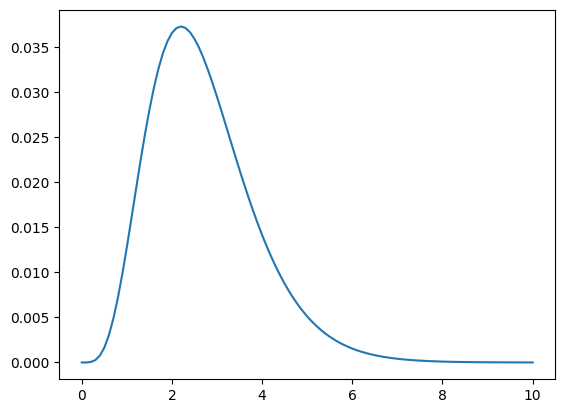

In [2]:
# Here's the world cup problem redone using conjugate prior.
from scipy.stats import gamma, poisson
import numpy as np
from utils import Pmf

def world_cup_prob(data):
    alpha = 1.4
    prior_dist = gamma(alpha)
    lams = np.linspace(0, 10, 101)
    prior = Pmf(prior_dist.pdf(lams), lams)
    likelihood = poisson(lams).pmf(data)
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

world_cup_posterior = world_cup_prob(4)
world_cup_posterior.plot()

<Axes: >

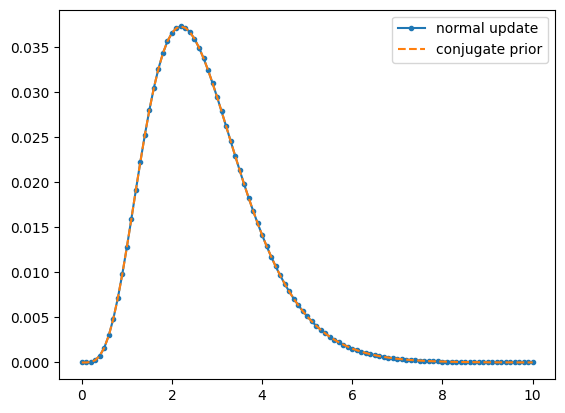

In [3]:
def make_gamma_dist(alpha, beta):
    """Makes a gamma object."""
    dist = gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

def world_cup_prob_conjugate_prior(data):
    alpha = 1.4
    beta = 1
    # prior_dist = make_gamma_dist(alpha, beta)
    posterior_dist = make_gamma_dist(alpha + data, beta + 1)
    
    lams = np.linspace(0, 10, 101)
    posterior = Pmf(posterior_dist.pdf(lams), lams)
    posterior.normalize()
    return posterior

world_cup_posterior = world_cup_prob(4)
world_cup_posterior.plot(label="normal update", style='.-', legend=True)
world_cup_posterior_cp = world_cup_prob_conjugate_prior(4)
world_cup_posterior_cp.plot(label="conjugate prior", style='--', legend=True)

In [4]:
# Let's look at the definition of gamma distribution:
#
# gamma(lam, alpha, beta) = lam^(alpha - 1) e^(-lam * beta)
# poisson(lam, k, t) = lam^k e^(-lam * t)
#
# Now if the gamma distr is the prior and we perform a bayesian update, it would
# mean we multiply the two together.
#
# gamma_posterior = (lam^(alpha - 1) e^(-lam * beta)) * (lam^k e^(-lam * t))
#                 = (lam^(alpha+k - 1) e^(-lam * (beta + t))
#                 = gamma(lam, alpha+k, beta+t)

<Axes: >

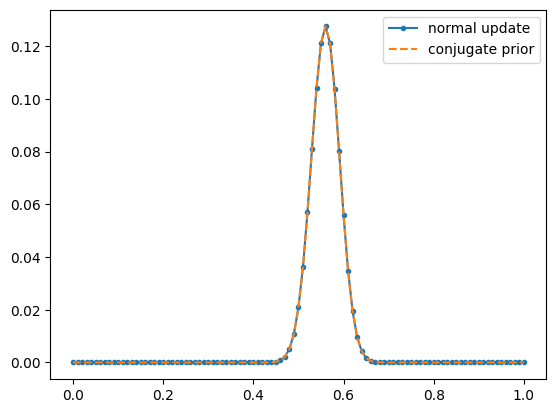

In [5]:
# Let's do the unfair coin problem, whose likelihood function follows
# a binomial distribution.
from scipy.stats import binom, beta

def euro_coin_problem(n_throws, n_head):    
    p_qs = np.linspace(0, 1, 101)
    prior = Pmf(1, p_qs)
    likelihood = binom.pmf(n_head, n_throws, p_qs)
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

def euro_coin_problem_conjugate_prior(n_throws, n_head):
    # NOTE: beta(1,1) describes a uniform distribution
    a = b = 1
    # prior_dist = beta(a, b)
    posterior_dist = beta(a+n_head, b+n_throws-n_head)
    p_qs = np.linspace(0, 1, 101)
    posterior = Pmf(posterior_dist.pdf(p_qs), p_qs)
    posterior.normalize()
    return posterior

euro_coin_posterior = euro_coin_problem(250, 140)
euro_coin_posterior.plot(label="normal update", style='.-', legend=True)
euro_coin_posterior_cp = euro_coin_problem_conjugate_prior(250, 140)
euro_coin_posterior_cp.plot(label="conjugate prior", style='--', legend=True)

0.019607843137254926 0.0196078431372549
max prob:  0.14 0.14 0.17


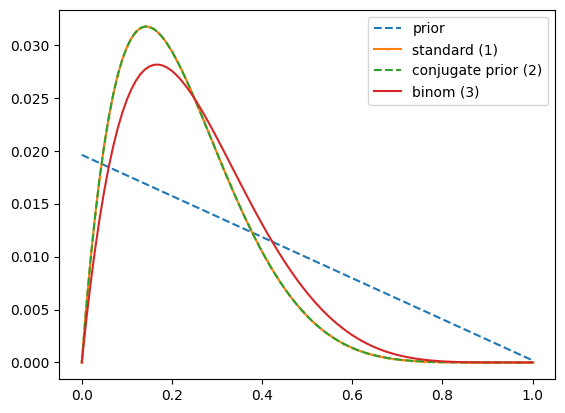

In [6]:
# Lions and Tigers and Bears problem. Suppose all animal appears at the likelihood of
# their proportion in a zoo. You saw 3 lions, 2 tigers and a bear. What's the
# chance you see a bear next?
#
# This problem describes the likelihood function is multinomial distribution.
# Its conjugate prior is the dirichlet distribution.

from scipy.stats import multinomial, dirichlet

def gen_hypos(q_ps):
    hypos = []
    for ai, a in enumerate(q_ps):
        for bi, b in enumerate(q_ps):
            ci = len(q_ps) - ai - bi - 1
            if ci < 0:
                continue
            # can't use c = 1 - a - b because that will run into floating point
            # precision problem where some c may not be equal to any element of q_ps.
            # this will cause problem in aggregation.
            c = q_ps[ci]
            hypos.append((a,b,c))
    return hypos

def zoo_problem_prior():
    q_ps = np.linspace(0.0, 1.0, 101)
    hypos = gen_hypos(q_ps)
    ps = [1 for _ in hypos]
    prior = Pmf(ps, hypos)
    prior.normalize()
    sum_bears = {p: 0 for p in q_ps}
    for (a,b,c) in prior.index:
       sum_bears[c] += prior[(a,b,c)]
    prior_marginal = Pmf(sum_bears, q_ps)
    return prior_marginal

def zoo_problem(lions, tigers, bears):
    data = [lions, tigers, bears]
    n = np.sum(data)
    q_ps = np.linspace(0.0, 1.0, 101)
    hypos = gen_hypos(q_ps)
    ps = [1 for _ in hypos]
    for i, (a,b,c) in enumerate(hypos):
        ps[i] *= multinomial.pmf(data, n, [a,b,c])
        pass
    posterior = Pmf(ps, hypos)
    posterior.normalize()
    sum_bears = {p: 0 for p in q_ps}
    for (a,b,c) in posterior.index:
       sum_bears[c] += posterior[(a,b,c)]
    bear_posterior = Pmf(sum_bears, q_ps)
    return bear_posterior

def zoo_problem_dirichlet(lions, tigers, bears):
    prior_params = np.array([1, 1, 1])
    data = np.array([lions, tigers, bears])
    posterior_params = prior_params + data
    posterior_dist = dirichlet(posterior_params)
    
    q_ps = np.linspace(0.0, 1.0, 101)
    quantiles = [np.array([a,b,c]) for (a,b,c) in gen_hypos(q_ps)]
    sum_bears = {p: 0 for p in q_ps}
    
    for qs in quantiles:
        sum_bears[qs[2]] += posterior_dist.pdf(qs)
    bear_posterior = Pmf(sum_bears, q_ps)
    bear_posterior.normalize()
    return bear_posterior

def zoo_problem_binom(lions, tigers, bears):
    q_ps = np.linspace(0.0, 1.0, 101)
    prior = Pmf(1, q_ps)
    likelihood = binom.pmf(bears, lions+tigers+bears, q_ps)
    posterior = Pmf(prior * likelihood)
    posterior.normalize()
    return posterior

prior = zoo_problem_prior()
answer1 = zoo_problem(3,2,1)
answer2 = zoo_problem_dirichlet(3,2,1)
answer3 = zoo_problem_binom(3,2,1)
print(prior.max(), 1/51)
prior.plot(style='--', ms=1, label="prior")
answer1.plot(style='.-', ms=1, label="standard (1)")
answer2.plot(style='--', ms=1, label="conjugate prior (2)")
answer3.plot(style='-', ms=1, label="binom (3)")
print('max prob: ', answer1.max_prob(), answer2.max_prob(), answer3.max_prob())

In [7]:
# The above result puzzled me a lot. It's surprising that the prior is not
# a uniform distribution. This makes sense because there are fewer
# possibility (combinations) for bear and tigers if bear has probability of 1.0, and there
# is maximum number of possibility (combinations) where bear has probability of 0.
#
# from an intuitive sense, we would argue that without prior knowledge about the
# number of animals, we should assume a 1/3 probability for any of them.
# however, counting the combinations indicates that actually the max_prob of the combinations
# is at the probability of 0 for any of the animals. i.e. the most likely probability for
# bears is 0. Here "most likely" is a little different from our usual sense of "likelihood".
# Turns out, the mean (expected value of the probs) is at 1/3.
prior.mean()

# The binom version gives a different answer by incorrectly assuming that the prior distribution
# of probability is actually a uniform distribution. This is obviously wrong because
# in that sense the expected probability for bear is 1/2, not 1/3.

0.33333333333333337

<Axes: >

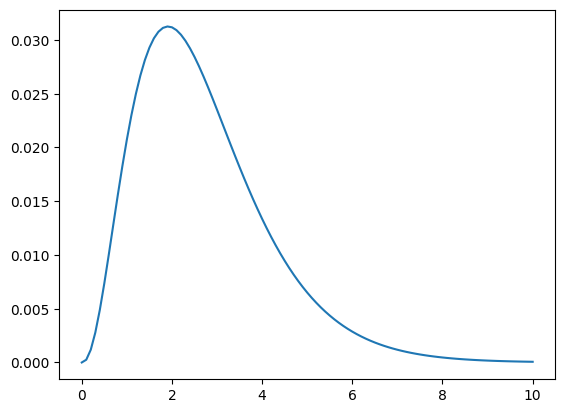

In [8]:
# Exercise 18-1: redo the world cup problem but this time, the data is not the number
# of goals per game but the time between goals. So the probability of the data follows
# an exponential distribution rather than a poisson distribution.
#
# Pdf for exponential distribution: lam * exp(-lam * t)
# Gamma(lam, alpha, beta) := lam^(alpha - 1) exp(-lam * beta)
#
# The updated Gamma would have:
# alpha' := alpha + 1
# beta' := beta + t

def ex_18_1(first_goal, second_goal):
    # prior
    alpha = 1.4
    beta = 1
    # first update
    alpha += 1
    beta += first_goal
    # second update
    alpha += 1
    beta += second_goal
    
    posterior_dist = make_gamma_dist(alpha, beta)
    lams = np.linspace(0, 10, 101)
    pmf = Pmf(posterior_dist.pdf(lams), lams)
    pmf.normalize()
    return pmf

ex_18_1(11/90, 12/90).plot()

(2.6, 2.6)


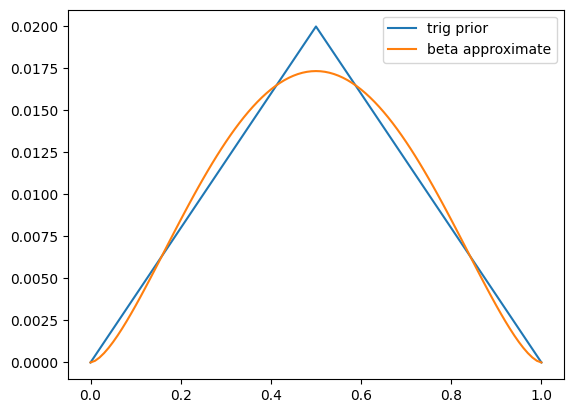

In [12]:
# Exercise 18-2: redo the euro coin problem. Now with a triangular prior. Find the approximation of
# triangular prior using beta distribution. Then use it to redo the problem.

def trig(hypos):
    ramp_up = np.arange(50)
    ramp_down = np.arange(50, -1, -1)
    a = np.append(ramp_up, ramp_down)
    triangle = Pmf(a, hypos, name='triangle')
    triangle.normalize()
    return triangle

def find_beta_param(target_pmf):
    hypos = target_pmf.qs
    params = [(a,b) for a in np.arange(0.1, 5, 0.1) for b in np.arange(0.1, 5, 0.1)]
    best_distance = np.inf
    best_param = None
    for i, (a,b) in enumerate(params):
        pmf = Pmf(beta(a, b).pdf(hypos), hypos)
        pmf.normalize()
        distance = np.sum(np.abs(pmf - target_pmf))
        if distance < best_distance:
            best_param = (a,b)
            best_distance = distance
    
    beta_prior = Pmf(beta(best_param[0], best_param[1]).pdf(hypos), hypos)
    beta_prior.normalize()
    return best_param, beta_prior

hypos = np.linspace(0, 1, 101)
trig_prior = trig(hypos)
beta_prior_param, beta_prior = find_beta_param(trig_prior)
trig_prior.plot(label="trig prior", legend=True)
beta_prior.plot(label="beta approximate", legend=True)
print(beta_prior_param)

<Axes: >

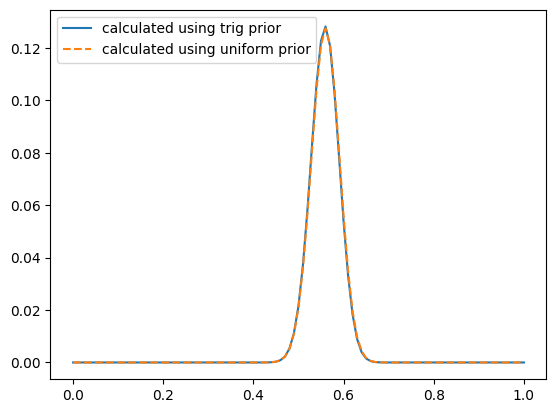

In [18]:
# now we run the update
def ex18_2_update(beta_prior_param, n_throws, n_head):
    a, b = beta_prior_param
    # prior_dist = beta(a, b)
    posterior_dist = beta(a+n_head, b+n_throws-n_head)
    p_qs = np.linspace(0, 1, 101)
    posterior = Pmf(posterior_dist.pdf(p_qs), p_qs)
    posterior.normalize()
    return posterior

ex18_2_posterior = ex18_2_update(beta_prior_param, 250, 140)
ex18_2_posterior.plot(label="calculated using trig prior", legend=True)
euro_coin_posterior_cp.plot(label="calculated using uniform prior", style='--', legend=True)
# the difference is barely visible as shown in the original sections on euro coin.

(0.87, 0.7998799952002403)

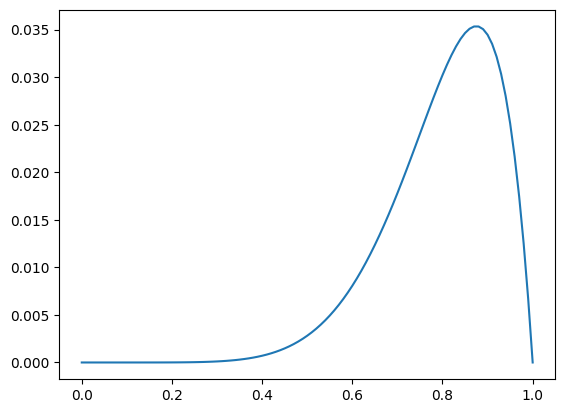

In [26]:
# Exercise 18-3: 3Blue1Brown's product review problem. Three products online:
# - The first: 100% positive rating from 10 reviews
# - The second: 96% positive rating from 50 reviews
# - The third: 93% positive rating from 200 reviews
# Which one would you buy?
#
# Modeling is by assuming there is a hidden probability x of
# providing satisfactory service and getting a positive review.
# So we choose the seller with highest x.

# Modeling the prior to be a beta distribution. The book suggest starting
# with beta distribution with alpha=8 and beta=2.
def beta_pmf(param):
    a, b = param
    p_qs = np.linspace(0, 1, 101)
    pmf = Pmf(beta(a, b).pdf(p_qs), p_qs)
    pmf.normalize()
    return pmf

ex_18_3_prior = (8, 2)
ex_18_3_prior_pmf = beta_pmf(ex_18_3_prior)
ex_18_3_prior_pmf.plot()
(ex_18_3_prior_pmf.max_prob(), ex_18_3_prior_pmf.mean())

the means:  0.8997150598793645 0.9333423698497898 0.92380952418551
prob vendor 2 has higher posterior mean than vendor 1:  0.6170015677573358
prob vendor 2 has higher posterior mean than vendor 3:  0.5856050974025673


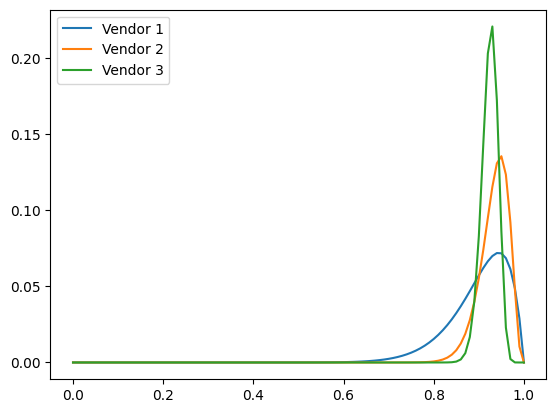

In [30]:
# Now let's update the prior with the data.
def ex_18_3_update(prior_param, pos_rate, n_reviews):
    a, b = prior_param
    pos_count = round(pos_rate * n_reviews)
    a += pos_count
    b += n_reviews - pos_count
    return (a, b)

ex_18_3_posterior_vendor_1 = ex_18_3_update(ex_18_3_prior, 1.0, 10)
ex_18_3_posterior_vendor_2 = ex_18_3_update(ex_18_3_prior, 0.96, 50)
ex_18_3_posterior_vendor_3 = ex_18_3_update(ex_18_3_prior, 0.93, 200)

ex_18_3_posterior_vendor_1_pmf = beta_pmf(ex_18_3_posterior_vendor_1)
ex_18_3_posterior_vendor_2_pmf = beta_pmf(ex_18_3_posterior_vendor_2)
ex_18_3_posterior_vendor_3_pmf = beta_pmf(ex_18_3_posterior_vendor_3)

ex_18_3_posterior_vendor_1_pmf.plot(label="Vendor 1")
ex_18_3_posterior_vendor_2_pmf.plot(label="Vendor 2")
ex_18_3_posterior_vendor_3_pmf.plot(label="Vendor 3")

print("the means: ",
  ex_18_3_posterior_vendor_1_pmf.mean(),
  ex_18_3_posterior_vendor_2_pmf.mean(),
  ex_18_3_posterior_vendor_3_pmf.mean())
print("prob vendor 2 has higher posterior mean than vendor 1: ",
      ex_18_3_posterior_vendor_2_pmf.prob_gt(ex_18_3_posterior_vendor_1_pmf))
print("prob vendor 2 has higher posterior mean than vendor 3: ",
      ex_18_3_posterior_vendor_2_pmf.prob_gt(ex_18_3_posterior_vendor_3_pmf))

the means:  0.8997150598793645 0.9333423698497898 0.92380952418551
prob vendor 2 has higher posterior mean than vendor 1:  0.6170015677573358
prob vendor 2 has higher posterior mean than vendor 3:  0.5856050974025673


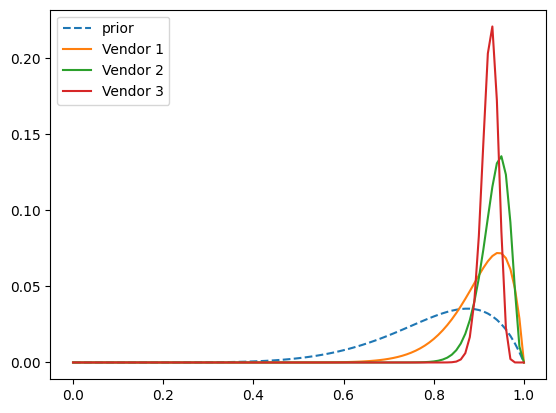

In [31]:
# change the prior to alpha=0.7 and beta=0.5 and rerun the update.

ex_18_3_prior_2 = (8, 2)
ex_18_3_prior_2_pmf = beta_pmf(ex_18_3_prior_2)
ex_18_3_prior_2_pmf.plot(label="prior", style="--")
(ex_18_3_prior_2_pmf.max_prob(), ex_18_3_prior_2_pmf.mean())

ex_18_3_posterior_vendor_1 = ex_18_3_update(ex_18_3_prior_2, 1.0, 10)
ex_18_3_posterior_vendor_2 = ex_18_3_update(ex_18_3_prior_2, 0.96, 50)
ex_18_3_posterior_vendor_3 = ex_18_3_update(ex_18_3_prior_2, 0.93, 200)

ex_18_3_posterior_vendor_1_pmf = beta_pmf(ex_18_3_posterior_vendor_1)
ex_18_3_posterior_vendor_2_pmf = beta_pmf(ex_18_3_posterior_vendor_2)
ex_18_3_posterior_vendor_3_pmf = beta_pmf(ex_18_3_posterior_vendor_3)

ex_18_3_posterior_vendor_1_pmf.plot(label="Vendor 1")
ex_18_3_posterior_vendor_2_pmf.plot(label="Vendor 2")
ex_18_3_posterior_vendor_3_pmf.plot(label="Vendor 3")

print("the means: ",
  ex_18_3_posterior_vendor_1_pmf.mean(),
  ex_18_3_posterior_vendor_2_pmf.mean(),
  ex_18_3_posterior_vendor_3_pmf.mean())
print("prob vendor 2 has higher posterior mean than vendor 1: ",
      ex_18_3_posterior_vendor_2_pmf.prob_gt(ex_18_3_posterior_vendor_1_pmf))
print("prob vendor 2 has higher posterior mean than vendor 3: ",
      ex_18_3_posterior_vendor_2_pmf.prob_gt(ex_18_3_posterior_vendor_3_pmf))

In [ ]:
# Exercise 18-4: already done